In [45]:
#paquetes utilizados
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import warnings
import math
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, het_arch
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smtsa
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import seasonal
from sklearn.metrics import r2_score
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Modelos autorregresivo integrado de media móvil

Apliquemos a continuación Modelos Autorregresivo Integrado de Media Móvil (ARIMA) a nuestra serie de tiempo, para conocer el comportamiento del pronóstico que se puede alcanzar a partir de estos. En este apartado estaremos aplicando:

1. ARIMA
2. SARIMA

Durante el análisis se estarán construyendo modelos para distintas combinaciones de autorregresivos, medias móviles y estacionalidades. Además para todos los pronósticos se considerará la técnica 'Rolling' que permite actualizar el modelo a medida que una nueva observación es conocida, lo que permite tener un pronóstico actualizado en el tiempo.

Cada una de los apartados a continuación incluyen funciones de creación, selección de mejor modelo y pronóstico. Carguemos los datos:

In [28]:
df=pd.read_excel("loadsts.xlsx")
df.index = df['Posted_date']
df.index.freq = 'D'
ts = df['Loads']

También carguemos las funciones que ya hemos utilizado anteriormente para el cálculo de los score de pronóstico, supuestos y separación de la serie de tiempo.

In [6]:
def split(serie, trainportion):
    perct = math.ceil(len(ts) * trainportion)
    perc2 = math.ceil(len(ts)*((1 - trainportion)/2))
    train = serie[0:perct]
    validation = serie[perct:perct+perc2]
    test = serie[perct+perc2:]
    return train, validation, test

In [7]:
#calculo de los errores
def errors(y_pred, y_real):
    
    mae = mean_absolute_error(y_real, y_pred)
    mape = 100*(sum(abs(((y_real - y_pred)/y_real)))/len(y_real))
    mse = mean_squared_error(y_real , y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)
    
    return mae, mape, mse, rmse, r2

In [8]:
#evaluacion de supuestos
def assumptions(residuals):

    warning = ""
    a = 0
    
    #Independency
    #H0: The residuals are independent.
    #H1: The residuals aren't independent.    
    ljung_box_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    ljung_box_pvalue = ljung_box_test['lb_pvalue'].values[0]
    if ljung_box_pvalue < 0.05:
        warning= warning + " The residuals aren't independent"
        a=a+1

    #Normality test
    #H0: The residuals have a normal distribution.
    #H1: The residuals don't have a normal distribution.
    jb_stat, jb_pvalue, skewness, kurtosis = jarque_bera(residuals)
    if jb_pvalue < 0.05:
        a = a+1
        warning = warning + " The residuals do not follow a normal distribution"

    #homocedasticity
    #H0: The residuals are homocedastic.
    #H1: The residuals aren't homocedastic.
    arch_stat, arch_pvalue, _, _ = het_arch(residuals)
    if arch_pvalue < 0.05:
        warning= warning + " The residuals aren't homocedastic"
        a=a+1

    return arch_pvalue, jb_pvalue, ljung_box_pvalue, warning

Para la construcción de los modelos ARIMA, utilizaremos 80% para el conjunto de entrenamiento. Dado que haremos pronóstico tipo rolling, probar modelos de alto orden con combinaciones de tipo p,q (3,3) supone alta disponibilidad computacional, y esto sucede no solo para testear validación sino para cada pronóstico del testing, y en cada observación el modelo se reentrena, esto lo hacemos para optimizar los tiempos de corrida del algoritmo.

In [29]:
train, val, test = split(ts, 0.8)

## 1. ARIMA

Para generar el modelo ARIMA que pronostica con la técnica de 'Rolling' se hace uso de dos funciones:
1. _arimaconrolling_: Esta función recibe los valores de p(AR), q(MA) y el set de training y testing. Para cada combinación p, q entrena el modelo usando la serie de tiempo de entrenamiento, pronostica el test y se encarga de guardar el valor de p y q con que se obtuvo el menor valor de error. Solo que en este caso el pronóstico se realiza a partir de la técnica de rolling, haciendo un llamado a la función del punto 2.
2. _arima_rolling_: Esta función calcula mediante rolling la cantidad de pasos de la serie de test que recibe. Luego de realizar cada pronóstico, esta función también reentrena el modelo para la combinación de p y q que recibe, porque actualiza la serie de tiempo input, agregando un valor real de la serie original de la variable de análisis.

In [32]:
## arima con rolling
#obtener el mejor modelo
def arimaconrolling(train, ts_test, p, d, q):
    warnings = []
    mae_list = []
    step = len(ts_test)
    best_p, best_q = None, None
    best_mae = float("inf")
    
    for ari in range(1, p+1): #p1
        for maj in range(1, q+1): #q
            arima_model = smtsa.ARIMA(train, order=(ari, d, maj)).fit()
            y_pred = arima_rolling(train, ts_test, ari, d, maj)
            print("Combinacion", ari, maj)
            mae = mean_absolute_error(ts_test, y_pred)

            residuals_m = arima_model.resid #obtención de residuales del modelo
            arch_pvalue, jb_pvalue, ljung_box_pvalue, warning = assumptions(residuals_m) #análisis de los residuales
            
            print("obtuvo un mae de", mae)
            print("obtuvo este warning", warning)
            mae_list.append(mae)
            warnings.append(warning)
            
            if mae < best_mae:
                best_p, best_q, best_mae = ari, maj, mae
        print("el mejor mae es", best_mae)
    return best_p, d, best_q, mae_list, warnings

## pronosticar con rolling
def arima_rolling(ts, test, p, d, q):
    predictions = []
    ts = ts.tolist()
    test = test.reset_index(drop=True)
    for t in range(len(test)):
        model = smtsa.ARIMA(ts, order = (p, d, q)).fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        ts.append(obs)
    return predictions

Durante el capítulo de Análisis Exploratorio de Datos observamos que la serie no era estacionaria y que era necesario aplicar una diferenciación para poder seleccionar el Autorregresivo y Media Móvil con que vamos a construir nuestro modelo de ARIMA. Analicemos que valor de p (AR) y q (MA) podemos utilizar para entrenar el modelo.

In [20]:
train_diff = train.diff()

<Figure size 550x550 with 0 Axes>

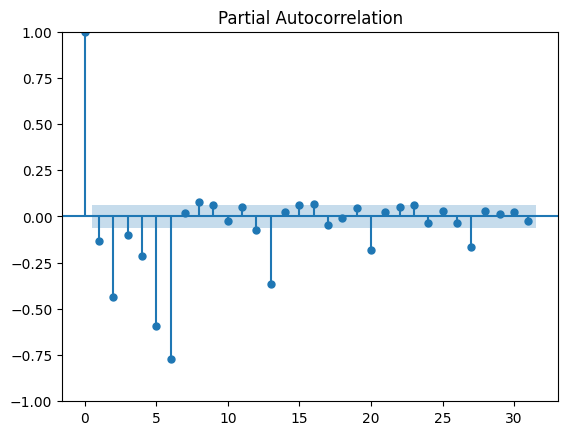

In [21]:
plt.figure(figsize=(5.5, 5.5));
plot_pacf(train_diff.dropna());

En la gráfica PACF, observamos un patrón repetirse cada dos o tres lags. Sobre todo los primeros 6 lags sobrepasan la banda de significancia por mucho. Seleccionaremos entrenar nuestro modelo para 1, 2 y 3 valores de p. p igual a 0 no es considerado, porque conocemos a priori que debemos captar la relación entre los lags, no hacerlo puede suponer fallar en la prueba de independencia.

<Figure size 550x550 with 0 Axes>

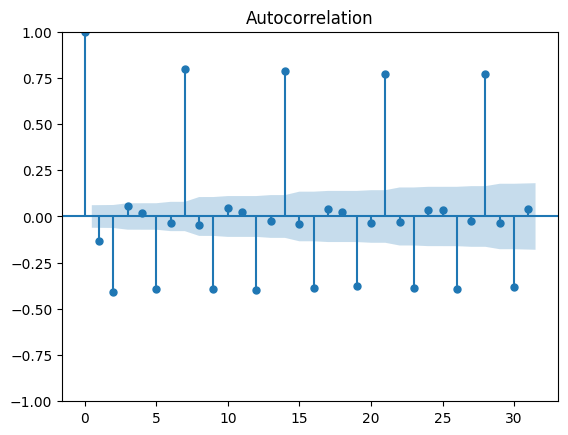

In [22]:
plt.figure(figsize=(5.5, 5.5));
plot_acf(train_diff.dropna());

En este gráfico de ACF el comportamiento es aún más explícito en que cada dos y tres lags una barra sobrepasa la banda de significancia, de nuevo, puede estar relacionado con el comportamiento en cada día de la semana de las cargas transportadas. Para el valor de q también seleccionaremos entrenar el modelo ARIMA para 1, 2, 3 lags. q igual a 0 no es considerado, porque conocemos a priori que debemos captar la relación entre los lags, no hacerlo puede suponer fallar en la prueba de independencia.

Además fijaremos el valor de d en el modelo como igual a 1.

In [33]:
#arima con rolling

best_p, d, best_q, mae_list, warnings = arimaconrolling(train, val, 3, 1, 3) #selección del mejor modelo

arima_model = smtsa.ARIMA(train, order=(best_p, d, best_q)).fit()
residuals_m = arima_model.resid #obtención de residuales del modelo
val_pred = arima_rolling(train, val, best_p, d, best_q) #pronosticar validación
mae_v, mape_v, mse_v, rmse_v, r2_v = errors(val_pred, val)  #scores validación
arch_pvalue, jb_pvalue, ljung_box_pvalue, warning = assumptions(residuals_m) #análisis de los residuales

Combinacion 1 1
obtuvo un mae de 17.444868471959694
obtuvo este warning  The residuals aren't independent The residuals do not follow a normal distribution The residuals aren't homocedastic


C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Combinacion 1 2
obtuvo un mae de 16.16622318975237
obtuvo este warning  The residuals do not follow a normal distribution The residuals aren't homocedastic
Combinacion 1 3
obtuvo un mae de 15.12996554896757
obtuvo este warning  The residuals do not follow a normal distribution The residuals aren't homocedastic
el mejor mae es 15.12996554896757
Combinacion 2 1
obtuvo un mae de 15.928834679484881
obtuvo este warning  The residuals do not follow a normal distribution The residuals aren't homocedastic


C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Combinacion 2 2
obtuvo un mae de 15.051050586165585
obtuvo este warning  The residuals do not follow a normal distribution The residuals aren't homocedastic
Combinacion 2 3
obtuvo un mae de 15.142133747064538
obtuvo este warning  The residuals aren't independent The residuals do not follow a normal distribution The residuals aren't homocedastic
el mejor mae es 15.051050586165585
Combinacion 3 1
obtuvo un mae de 16.028683346729785
obtuvo este warning  The residuals aren't homocedastic


C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Combinacion 3 2
obtuvo un mae de 15.77079257831802
obtuvo este warning  The residuals do not follow a normal distribution The residuals aren't homocedastic
Combinacion 3 3
obtuvo un mae de 14.097626413561988
obtuvo este warning  The residuals aren't independent The residuals do not follow a normal distribution The residuals aren't homocedastic
el mejor mae es 14.097626413561988


A partir del entrenamiento del modelo ARIMA, distintas opciones de modelo para las distintas combinaciones se generaron. Podemos crear una tabla donde observemos mejor el comportamiento que cada uno tuvo, seleccionaremos un modelo que cumpla al menos el supuesto de independencia y que además haya alcanzado el mejor MAE.

In [97]:
combs = []
for p in range(1,4):
    for q in range(1,4):
        combs.append(f"({p:.2f}, {q:.2f})")

In [98]:
arima_results = {'comb': combs, 'assumptions': warnings, 'mae': mae_list}
arima_results = pd.DataFrame(arima_results)

In [99]:
arima_results

,comb,assumptions,mae
0,"(1.00, 1.00)",The residuals aren't independent The residual...,17.444868
1,"(1.00, 2.00)",The residuals do not follow a normal distribu...,16.166223
2,"(1.00, 3.00)",The residuals do not follow a normal distribu...,15.129966
3,"(2.00, 1.00)",The residuals do not follow a normal distribu...,15.928835
4,"(2.00, 2.00)",The residuals do not follow a normal distribu...,15.051051
5,"(2.00, 3.00)",The residuals aren't independent The residual...,15.142134
6,"(3.00, 1.00)",The residuals aren't homocedastic,16.028683
7,"(3.00, 2.00)",The residuals do not follow a normal distribu...,15.770793
8,"(3.00, 3.00)",The residuals aren't independent The residual...,14.097626


Del anterior ciclo 9 modelos fueron evaluados. El de mejor desempeño en cuanto al MAE, fue el modelo (3,3) con un valor de 14 cargas de diferencia en el pronóstico. Es el menor MAE alcanzado hasta el momento, sin embargo, esta combinación contiene residuales que no cumplen el supuesto de independencia, es posible que existan aún correlaciones entre los residuos que no se logran modelar adecuadamente y los rezagos pueden afectar el pronóstico del modelo. 

Observamos además que varios de los modelos no cumplen el supuesto de homocedasticidad, aspecto que habíamos anticipado anteriormente. Existe alta variabilidad en el número de cargas diarias reservadas por esta empresa, lo que también afecta el supuesto de normalidad, sin embargo en este proyecto no buscamos calcular intervalos de confianza.

Como mejor modelo ARIMA entonces seleccionaremos el modelo (2,2). Esto dado que con él alcanzamos el segundo mejor MAE de los calculados con aproximadamente una carga más de diferencia al modelo (3,3). Es probable, sin embargo, que con este modelo no obtengamos un resultado ideal, dado el supuesto de heterocedasticidad que no se cumple, ante horizontes largos de tiempo como el del test que tenemos planteado, podría tener una varianza que afecte el resultado considerablemente. 

Conociendo esta limitación, buscaríamos reducir el impacto de esta no homocedasticidad, con el uso de la técnica rolling. 

Guardemos los resultados para la validación de este modelo y calculemos otras métricas adicionales.

In [111]:
#Modelo ARIMA con Rolling

arima_model = smtsa.ARIMA(train, order=(2, 1, 2)).fit()
residuals_m = arima_model.resid #obtención de residuales del modelo
val_pred = arima_rolling(train, val, 2, 1, 2) #pronosticar validación
mae_v, mape_v, mse_v, rmse_v, r2_v = errors(val_pred, val) #scores validación
arch_pvalue, jb_pvalue, ljung_box_pvalue, warning = assumptions(residuals_m) #análisis de los residuales

C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Analicemos el desempeño de este modelo para el pronóstico del conjunto de test.

In [112]:
#arima con rolling
val_result = []
test_result = []

#forecast testing con arima
tt = pd.concat([train,val]) #unir validación con training
arima_model = smtsa.ARIMA(tt, order=(2, 1, 2)).fit()
test_pred = arima_rolling(tt, test, 2, 1, 2) #pronosticar el testing
mae_t, mape_t, mse_t, rmse_t, r2_t = errors(test_pred, test) #scores testing

val_result.append(["arima", mape_v, mae_v, mse_v, rmse_v, r2_v, arch_pvalue, jb_pvalue, ljung_box_pvalue, warning])
test_result.append(["arima", mape_t, mae_t, mse_t, rmse_t, r2_t])

C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## 2. SARIMA

El modelo SARIMA además del componente de autorregresivo y media móvil que considera el modelo ARIMA, agrega el análisis de la componente estacional de la serie.

Para generar el modelo SARIMA que pronostica con la técnica de 'Rolling' se hace uso de dos funciones:
1. _sarimaconrolling_: Esta función recibe los valores de p(AR), q(MA) y el set de training y testing. Además se agregan los parámetros P y Q correspondientes a los autorregresivos y media móvil de la componente estacional. Para cada combinación p, q, P, Q entrena el modelo usando la serie de tiempo de entrenamiento, pronostica el test y se encarga de guardar el valor de p y q con que se obtuvo el menor valor de error. Solo que en este caso el pronóstico se realiza a partir de la técnica de rolling, haciendo un llamado a la función del punto 2.
    Esta función además considera los casos de error en que los componentes de P, Q, p y q no pueden ser iguales a la componente estacional s. Es decir, no todas las combinaciones, de hecho, pueden ser evaluadas.
   
3. _sarima_rolling_: Esta función calcula mediante rolling la cantidad de pasos de la serie de test que recibe. Luego de realizar cada pronóstico, esta función también reentrena el modelo para la combinación de p, q, P, Q que recibe, porque actualiza la serie de tiempo input, agregando un valor real de la serie original de la variable de análisis.

In [ ]:
## sarima con rolling
#obtener el mejor modelo
def sarimaconrolling(train, ts_test, p, q, P, Q):
    warnings = []
    mae_list = []
    step = len(ts_test)
    best_p, best_q, best_Q, best_P, best_s = None, None, None, None, None
    best_mae = float("inf")

    for ari in range(1, p+1): #p 1, 2, 3
        for maj in [3]: #q 1, 2, 3
            for ps in range (1, P+1): #P 1, 2
                for qs in range (1, Q+1): #Q 1,2 
                    for s in range (2, 4): #s 2,3
                        if ari !=s and maj != s and ps != s and qs != s:  
                            print("Combinacion", ari, maj, ps, qs, s)
                            try:
                                print("Combinacion", ari, maj, ps, qs, s)
                                mod = sm.tsa.statespace.SARIMAX(train, trend='n', order=(ari, 1, maj),
                                                                seasonal_order=(ps, 0, qs, s)).fit()
                                y_pred = sarima_rolling(train, ts_test, ari, maj, ps, qs, s)
                                mae = mean_absolute_error(ts_test, y_pred)
                                print("obtuvo un mae de", mae)
                                residuals_m = mod.resid #obtención de residuales del modelo
                                arch_pvalue, jb_pvalue, ljung_box_pvalue, warning = assumptions(residuals_m) #análisis de los residuales
                                print("obtuvo este warning", warning)
                                mae_list.append(mae)
                                warnings.append(warning)
                                
                                if mae < best_mae:
                                    best_p, best_q, best_Q, best_P, best_s, best_mae = ari, maj, qs, ps, s, mae
                        
                            except ValueError as e:
                                print(f"Modelo inválido para la combinación ({ari}, {maj}, {ps}, {qs}, {s}): {e}")

                        print("el mejor mae es", best_mae)
                        
    return best_p, best_q, best_Q, best_P, best_s, mae_list, warnings

## pronosticar con rolling
def sarima_rolling(ts, test, p, q, P, Q, s):
    predictions = []
    ts = ts.tolist()
    mae_list = []
    test = test.reset_index(drop=True)
    for t in range(len(test)):
        fit = sm.tsa.statespace.SARIMAX(ts, trend='n', order=(p, 1, q),seasonal_order=(P, 0, Q, s)).fit()
        output = fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        ts.append(obs)
        print(test[:t+1])
        print(yhat)
        mae = mean_absolute_error(test[:t+1], predictions)
        mae_list.append(mae)
    return predictions

Para iniciar el entrenamiento del modelo SARIMA, debemos conocer el comportamiento de la componente estacional de la serie de tiempo, para ello haremos una descomposición de nuevo y analizaremos con la prueba de Dickey-Fuller y la ACF y la PACF la componente estacional.

In [48]:
ts_seasonal = seasonal_decompose(train,period = 7, model='additive').seasonal

El parámetro D en el modelo SARIMA está conectado con la necesidad de diferenciar la componente estacional si aplica, es por ello que debemos realizar una prueba de dickey-fuller sobre la componente estacional obtenida anteriormente. Observemos los resultados:

In [49]:
#H0: La serie no es estacionaria
#H1: La serie es estacionaria
adf_result = adfuller(ts_seasonal, autolag='AIC')
if adf_result[1] < 0.05:
    print("La serie es estacionaria, el p-valor de la prueba es", adf_result[1])
if adf_result[1] > 0.05:
    print("La serie no es estacionaria, el p-valor de la prueba es", adf_result[1])

La serie no es estacionaria, el p-valor de la prueba es 0.9585320860598399


Como se observa en la prueba, es necesario diferenciar la componente estacional.

In [115]:
adf_result = adfuller(ts_seasonal.diff().dropna(), autolag='AIC')
if adf_result[1] < 0.05:
    print("La serie es estacionaria, el p-valor de la prueba es", adf_result[1])
if adf_result[1] > 0.05:
    print("La serie no es estacionaria, el p-valor de la prueba es", adf_result[1])

La serie es estacionaria, el p-valor de la prueba es 0.0


Solo fue necesaria una diferenciación para conseguir la estacionariedad de esta componente.

El siguiente paso es estimar los valores de P y Q de la componente estacional, para ello se realiza el mismo proceso que en el caso de ARIMA de analizar con la ACF y la PACF la serie de tiempo, en este caso diferenciada.

Con la PACF observamos un comportamiento ocurrente cada dos rezagos, sobre todo pronunciado en el rezago sexto de la serie de tiempo. Utilizaremos P = 2 en este caso para evaluar el modelo.

<Figure size 550x550 with 0 Axes>

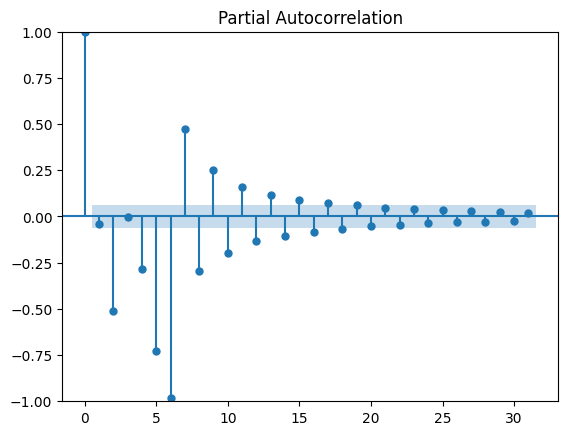

In [51]:
plt.figure(figsize=(5.5, 5.5));
plot_pacf(ts_seasonal.diff().dropna());
## valor de P = 2

Con la ACF observamos un comportamiento ocurrente cada dos y tres rezagos. Para evitar complejidades en los modelos presentados y disminuir el tiempo computacional de corrida de evluación de distintos modelos, utilizaremos Q = 2 en este caso para evaluar el modelo.

<Figure size 550x550 with 0 Axes>

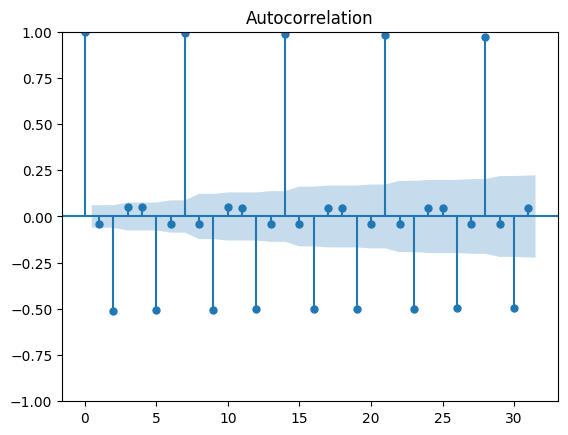

In [52]:
plt.figure(figsize=(5.5, 5.5));
plot_acf(ts_seasonal.diff().dropna());
#valor de q=2

Conociendo los parámetros p, q, P y Q, con los que evaluaremos la construcción de los modelos SARIMA podemos iniciar el testing de las distintas combinaciones y el MAE resultante. Un aspecto a considerar en el ciclo, es que ninguna variable es inicializada en cero, esto dado que es bastante evidente de que se debe tener en cuenta al menos una componente autorregresiva o de medio móvil tanto en la estacionalidad como en la serie de tiempo.

In [116]:
#sarima con rolling
#selección del mejor modelo
best_p, best_q, best_Q, best_P, best_s, mae_list, warnings = sarimaconrolling(train, val, 3, 3, 2, 2) 

Este ciclo fue evaluado para dos casos, para cuando D = 0 y cuando D = 1. Se observó que los MAE resultantes aumentaron considerablemente para todos los casos cuando se diferenció la componente estacional, a diferencia de cuando se mantuvo el parámetro D = 0. Con el fin de optimizar el procesamiento de los modelos, el ciclo se evaluó para todas las combinaciones posibles solo con D = 0. Estos son los resultados que se obtuvieron para ambos casos:

In [120]:
combs = ["(1 1 1 1 2)", "(1 1 1 1 3)", "(1 1 1 2 2)", "(1 1 1 2 3)", "(1 1 2 1 2)", "(1 1 2 1 3)",
         "(1 1 2 2 2)", "(1 1 2 2 3)", "(1 2 1 1 3)", "(1 2 1 2 3)", "(1 2 2 1 3)", "(1 2 2 2 3)"]
maeD0 = [15.251538393036853, 17.353808540598877, 14.695375844692176, 15.27593750773718, 13.954385435295077, 17.08781612812365,
        14.069640854145376, 13.078782929156546, 15.891079517448386, 14.85722756390012, 15.817005733206608, 13.096205042088233]
warningsD0 = ["The residuals do not follow a normal distribution The residuals aren't homocedastic",
             "The residuals do not follow a normal distribution The residuals aren't homocedastic",
             "The residuals do not follow a normal distribution The residuals aren't homocedastic",
             "The residuals do not follow a normal distribution The residuals aren't homocedastic",
             "The residuals do not follow a normal distribution The residuals aren't homocedastic",
             "The residuals do not follow a normal distribution The residuals aren't homocedastic",
             "The residuals do not follow a normal distribution The residuals aren't homocedastic",
             "The residuals do not follow a normal distribution The residuals aren't homocedastic",
             "The residuals aren't independent The residuals do not follow a normal distribution The residuals aren't homocedastic",
             "The residuals aren't independent The residuals do not follow a normal distribution The residuals aren't homocedastic",
             "The residuals aren't independent The residuals do not follow a normal distribution The residuals aren't homocedastic",
             "The residuals aren't independent The residuals do not follow a normal distribution The residuals aren't homocedastic"]

In [121]:
comb = ["(1 1 1 1 2)", "(1 1 1 1 3)", "(1 1 1 2 2)", "(1 1 1 2 3)"]
maeD1 = [16.02151424449377, 17.42859487514871, 15.469471990912764, 16.85052496583678]
warningsD1 = ["The residuals do not follow a normal distribution The residuals aren't homocedastic",
              "The residuals do not follow a normal distribution The residuals aren't homocedastic",
              "The residuals do not follow a normal distribution The residuals aren't homocedastic",
              "The residuals aren't independent The residuals aren't homocedastic"]

In [127]:
data_D1 = {'comb': comb, 'MAE_D1': maeD1, 'Warnings_D1': warningsD1}
df_D1 = pd.DataFrame(data_D1)

data_D0 = {'comb': combs, 'MAE_D0': maeD0, 'Warnings_D0': warningsD0}
df_D0 = pd.DataFrame(data_D0)

df_combined = pd.merge(df_D1, df_D0, on='comb', how='outer')
df_combined

,comb,MAE_D1,Warnings_D1,MAE_D0,Warnings_D0
0,(1 1 1 1 2),16.021514,The residuals do not follow a normal distribut...,15.251538,The residuals do not follow a normal distribut...
1,(1 1 1 1 3),17.428595,The residuals do not follow a normal distribut...,17.353809,The residuals do not follow a normal distribut...
2,(1 1 1 2 2),15.469472,The residuals do not follow a normal distribut...,14.695376,The residuals do not follow a normal distribut...
3,(1 1 1 2 3),16.850525,The residuals aren't independent The residuals...,15.275938,The residuals do not follow a normal distribut...
4,(1 1 2 1 2),NaN,NaN,13.954385,The residuals do not follow a normal distribut...
5,(1 1 2 1 3),NaN,NaN,17.087816,The residuals do not follow a normal distribut...
6,(1 1 2 2 2),NaN,NaN,14.069641,The residuals do not follow a normal distribut...
7,(1 1 2 2 3),NaN,NaN,13.078783,The residuals do not follow a normal distribut...
8,(1 2 1 1 3),NaN,NaN,15.891080,The residuals aren't independent The residuals...
9,(1 2 1 2 3),NaN,NaN,14.857228,The residuals aren't independent The residuals...


Como se observa en la tabla, para las 4 primeras combinaciones, en todos los casos diferenciar la componente estacional aumentó el MAE de la combinación. Al igual que en el análisis anterior los modelos no cumplen todos los supuestos, existen problemas de homocedasticidad que también pueden estar afectando la normalidad de la serie. Considerando el MAE, seleccionaremos como mejor modelo, la combinación p = 1, d = 1, q = 1, P = 2, D = 0, Q = 2 y s = 3.

Entrenemos el modelo con estos parámetros para guardar de nuevo los resultados de la validación más otros scores de pronóstico.

In [132]:
#Modelo SARIMA con Rolling

sarima_model = sm.tsa.statespace.SARIMAX(train, trend='n', order=(1, 1, 1),
                                                            seasonal_order=(2, 0, 2, 3)).fit()
residuals_m = sarima_model.resid #obtención de residuales del modelo
val_pred = sarima_rolling(train, val, 1, 1, 2, 2, 3) #pronosticar validación
mae_v, mape_v, mse_v, rmse_v, r2_v = errors(val_pred, val) #scores validación
arch_pvalue, jb_pvalue, ljung_box_pvalue, warning = assumptions(residuals_m) #análisis de los residuales

Ahora evaluemos el desempeño del modelo para pronosticar nuestro conjunto de test.

In [133]:
#SARIMA con Rolling

#forecast testing con SARIMA con Rolling

arima_model = sm.tsa.statespace.SARIMAX(tt, trend='n', order=(1, 1, 1),
                                                            seasonal_order=(2, 0, 1, 3)).fit()
test_pred = sarima_rolling(tt, test, 1, 1, 2, 1, 3) #pronosticar el testing
mae_t, mape_t, mse_t, rmse_t, r2_t = errors(test_pred, test) #scores testing

val_result.append(["sarima", mape_v, mae_v, mse_v, rmse_v, r2_v, arch_pvalue, jb_pvalue, ljung_box_pvalue, warning])
test_result.append(["sarima", mape_t, mae_t, mse_t, rmse_t, r2_t])

In [134]:
dfval = pd.DataFrame(val_result, columns=['model', 'MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'arch_pvalue', 'jb_pvalue', 'ljung_box_pvalue', 'warning'])
dftest = pd.DataFrame(test_result, columns=['model', 'MAPE', 'MAE', 'MSE', 'RMSE', 'R2']) 

In [140]:
dftest.to_excel("results/arimatest.xlsx")
dfval.to_excel("results/arimaval.xlsx")

## 4. Resultados

En este punto ya hemos seleccionado tanto para ARIMA como SARIMA el mejor modelo con base en el MAE de pronóstico del conjunto de Validación. A comparación de los modelos de suavización tuvimos en cuenta realizar un pronóstico a partir de la técnica de Rolling, a priori se planteó que esto podía mejorar considerablemente el desempeño en el pronóstico aspecto que se comprobó durante los conjuntos de validación donde el MAE obtenido mejoró en varias unidades.

Observemos a detalle el rendimiento de ambos modelos para validación y test, además de otras métricas adicionales calculadas.

### 4.1 Resultados en el entrenamiento de los modelos

In [138]:
dfval['parameters'] = ['(2,1,2)','(1,1,1)(2, 0, 2, 3)']
dfval

,model,MAPE,MAE,MSE,RMSE,R2,arch_pvalue,jb_pvalue,ljung_box_pvalue,warning,parameters
0,arima,inf,15.051051,323.407261,17.983527,0.247404,8.338575e-08,4.252854e-22,0.461667,The residuals do not follow a normal distribu...,"(2,1,2)"
1,sarima,inf,13.078783,247.766921,15.740614,0.423426,2.492835e-15,8.061886e-41,0.171245,The residuals do not follow a normal distribu...,"(1,1,1)(2, 0, 2, 3)"


**Key insights**
1. Claramente podemos observar que el R2 mejoró bastante con respecto a los modelos de suavización, que el mayor valor que alcanzaron fue de -0.09. Este tipo de modelos empieza a capturar de mejor forma la variabilidad de los datos, además los patrones de estacionalidad y tendencia de la serie. Sobre todo el modelo SARIMA que alcanzó un 42% de R2.
2. SARIMA de hecho presentó los valores de error más bajos hasta el momento alcanzando un valor de 13 cargas como MAE, esto puede deberse a la capacidad de modelar el componente estacional que tiene la serie diaria.
3. Al menos en el entrenamiento, ambos modelos tuvieron mucho mejor desempeño que las suavizaciones del capítulo anterior.
4. Aunque en ambos casos se utilizó p, q de rango 3, en SARIMA los valores de p, q se mantuvieron en un rezago, mientras que ARIMA obtuvo su mejor modelo con dos en cada caso.
5. El componente estacional de SARIMA fue 3, mientras que el de Holt-Winters fue 4, se puede analizar la posibilidad de aumentar el límite del ciclo para conocer si estacionalidades de mayor orden permiten mejorar el desempeño del modelo.
6. Ninguno de los dos modelos cumple los supuestos de normalidad y heterocedasticidad lo que pueden generar problemas posteriores en el pronóstico.
7. En este caso ambos modelos cumplen el supuesto de independencia.

A continuación comparemos si en el test, los resultados mantienen al modelo SARIMA como mejor modelo.

### 4.2 Resultados en el conjunto de test

In [139]:
dftest['parameters'] = ['(2,1,2)','(1,1,1)(2, 0, 2, 3)']
dftest

,model,MAPE,MAE,MSE,RMSE,R2,parameters
0,arima,inf,14.242388,273.714722,16.544326,0.239715,"(2,1,2)"
1,sarima,inf,16.311696,354.120036,18.818077,0.016377,"(1,1,1)(2, 0, 2, 3)"


**Key insights**
1. Sorprendentemente el modelo SARIMA bajó bastante su desempeño al pronosticar el testing, de hecho de tener un 42% de R2 disminuyó a casi 0%. Esto puede ser un índice de sobreajuste del modelo, se debe evaluar a profundidad.
2. ARIMA mejoró sus numeros de MAE, MSE y RMSE, durante el pronóstico del test y hasta ahora es el valor de MAE más bajo captado durante el testing de cargas. 
3. La búsqueda de modelar la estacionalidad aún no da resultado ni con SARIMA ni con Holt-Winters, la ausencia de homocedasticidad puede generar fallas en la precisión del pronóstico.

### 4.3 Selección del mejor modelo

En las técnicas de ARIMA y SARIMA podemos observar que en definitiva la técnica de Rolling beneficia el pronóstico del modelo. A pesar de que SARIMA presentó un buen desempeño durante la validación no lo mantuvo en el test, probablemente relacionado con sobreajuste y ARIMA solo a partir del análisis de tendencia alcanzó el mejor MAE hasta el momento.

En este estudio no se mostraron las opciones de transformación de datos, pero testeos preliminares de la autora corroboraron que incluso con transformadas de Box-cox y logarítmicas, los datos no cumplían el supuesto de normalidad ni heterocedasticidad.

Construyamos de nuevo el modelo ARIMA para graficar su pronóstico.

In [144]:
tt = pd.concat([train,val]) #unir validación con training
arima_model = smtsa.ARIMA(tt, order=(2, 1, 2)).fit()
test_pred_normal = arima_model.forecast(len(test))
test_pred_roll = arima_rolling(tt, test, 2, 1, 2) #pronosticar el testing
mae_t, mape_t, mse_t, rmse_t, r2_t = errors(test_pred_roll, test) #scores testing
mae_tn, mape_tn, mse_tn, rmse_tn, r2_tn = errors(test_pred_normal, test) #scores testing

C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


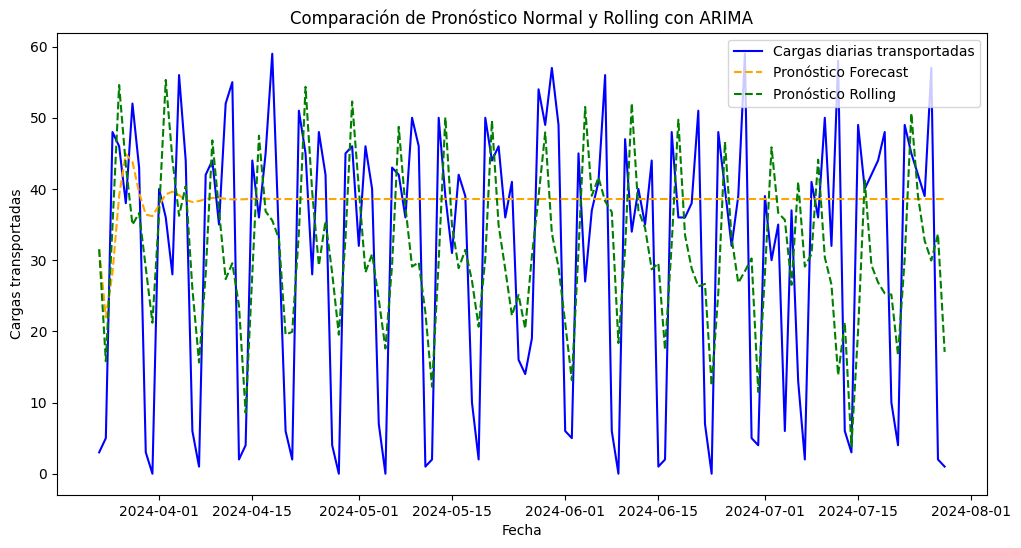

In [145]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Cargas diarias transportadas', color='blue')
plt.plot(test.index, test_pred_normal, label='Pronóstico Forecast', color='orange', linestyle='--')
plt.plot(test.index, test_pred_roll, label='Pronóstico Rolling', color='green', linestyle='--')
plt.title('Comparación de Pronóstico Normal y Rolling con ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Cargas transportadas')
plt.legend()
plt.show()

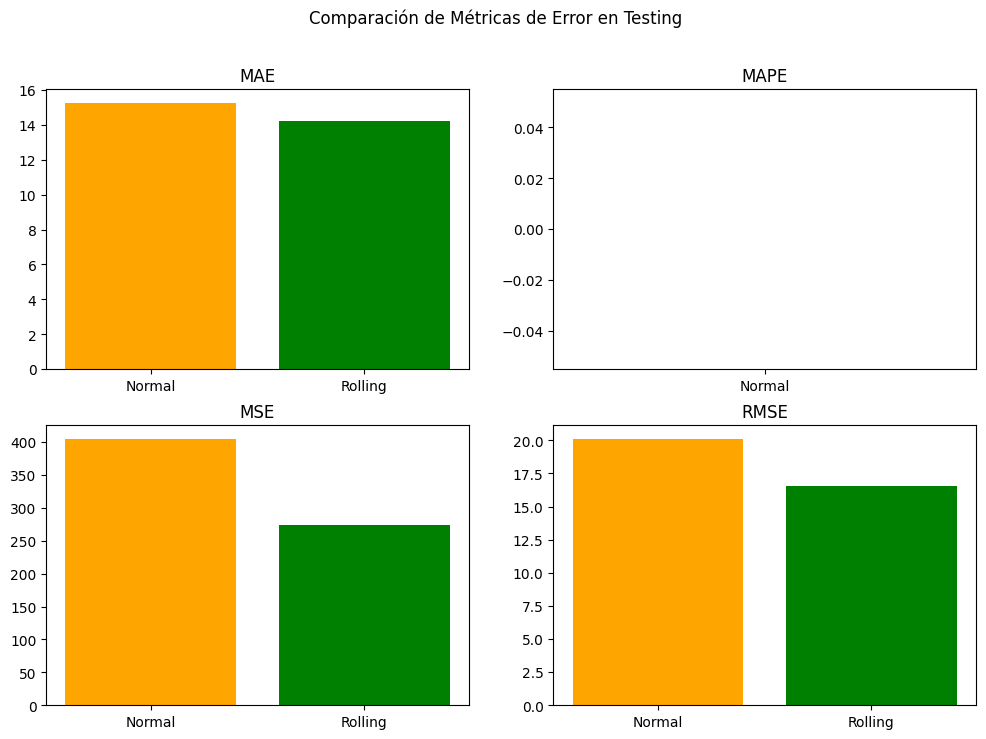

In [146]:
labels = ['Normal', 'Rolling']
maes = [mae_tn, mae_t]
mapes = [mape_tn, mape_t]
mses = [mse_tn, mse_t]
rmses = [rmse_tn, rmse_t]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].bar(labels, maes, color=['orange', 'green'])
axs[0, 0].set_title('MAE')
axs[0, 1].bar(labels, mapes, color=['orange', 'green'])
axs[0, 1].set_title('MAPE')
axs[1, 0].bar(labels, mses, color=['orange', 'green'])
axs[1, 0].set_title('MSE')
axs[1, 1].bar(labels, rmses, color=['orange', 'green'])
axs[1, 1].set_title('RMSE')
plt.suptitle('Comparación de Métricas de Error en Testing')
plt.show()

Como podemos observar en este gráfico de barras el modelo de Rolling tiene mejor desempeño en las métricas, comprobando una vez más que esta técnica soporta la heterocedasticidad en las predicciones.